In [1]:
! nvidia-smi

Thu Jan 20 14:11:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download alxmamaev/flowers-recognition

 98% 221M/225M [00:01<00:00, 162MB/s]
100% 225M/225M [00:01<00:00, 160MB/s]


In [ ]:
! unzip flowers-recognition.zip

In [6]:
train = '/content/flowers'

In [7]:
import tensorflow as tf
import keras
from PIL import Image
import os
from pathlib import Path
import numpy as np 

tf.__version__

'2.7.0'

In [8]:
dir = Path(train)

In [9]:
cnt = len(list(dir.glob('*/*.jpg')))
cnt

4317

In [10]:
size = 150

import cv2 as cv 

def resize(dir):
  for i in os.listdir(dir):
    for img in list(dir.glob(i+'*/*.jpg')):
      im = Image.open(img)
      im = im.resize((size, size))
      im.save(img)

resize(dir)

In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [12]:
rose = list(dir.glob('rose/*'))
img = Image.open(str(rose[12]))
width, height = img.size
width, height

(150, 150)

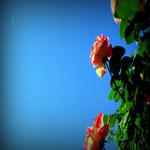

In [13]:
Image.open(rose[0])

In [14]:
batch_size, img_height, img_width = 32, height, width

In [15]:
train = tf.keras.utils.image_dataset_from_directory(
    dir, 
    validation_split=0.2,
    seed=123,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dir, 
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=123,
    validation_split=0.1,
    subset = "validation"
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 431 files for validation.


In [16]:
node = len(train.class_names)
node

5

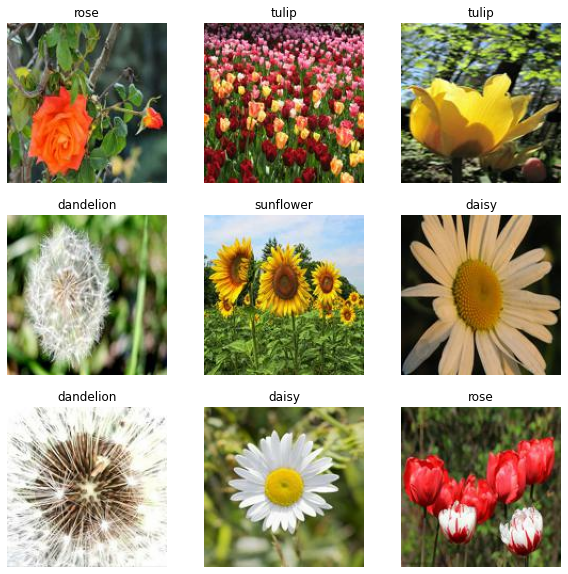

In [17]:
plt.figure(figsize=(10, 10))
for image, label in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(train.class_names[label[i]]) 
    plt.axis('off')

In [18]:
for i, l in train:
  print(i.shape, l.shape)
  break

(32, 150, 150, 3) (32,)


In [34]:
from keras.layers import Input, Rescaling, Conv2D, MaxPool2D, Flatten, Dense, Dropout, add
from keras.models import Model, Sequential

In [20]:
inputs = Input(shape=(height, width, 3))
rescale = Rescaling(1./255)(inputs)

# model 1 
m1 = Conv2D(16, (3, 3), padding='same', activation='relu', strides=1)(rescale)
m1 = Conv2D(32, (3, 3), padding='same', activation='relu', strides=1)(m1)
m1 = Conv2D(64, (3, 3), padding='same', activation='relu', strides=1)(m1)

# model 2
m2 = Conv2D(32, (3, 3), padding='same', activation='relu', strides=1)(rescale)
m2 = Conv2D(64, (3, 3), padding='same', activation='relu', strides=1)(m2) 
mm2 = Conv2D(64, (3, 3), padding='same', activation='relu', strides=1)(m2)

# addition model 
modelAdd = tf.keras.layers.add([m1,m2,mm2])
c3 = Conv2D(32, (3, 3), padding='same', activation='relu', strides=1)(modelAdd)
mx3 = MaxPool2D()(c3)
d3 = Dropout(0.5)(mx3)

flatten = Flatten()(d3)
dense = Dense(128, activation='relu')(flatten)
outputs = Dense(node, activation='softmax')(dense)


model = Model(
   inputs=inputs,
   outputs=outputs 
)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 16  448         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

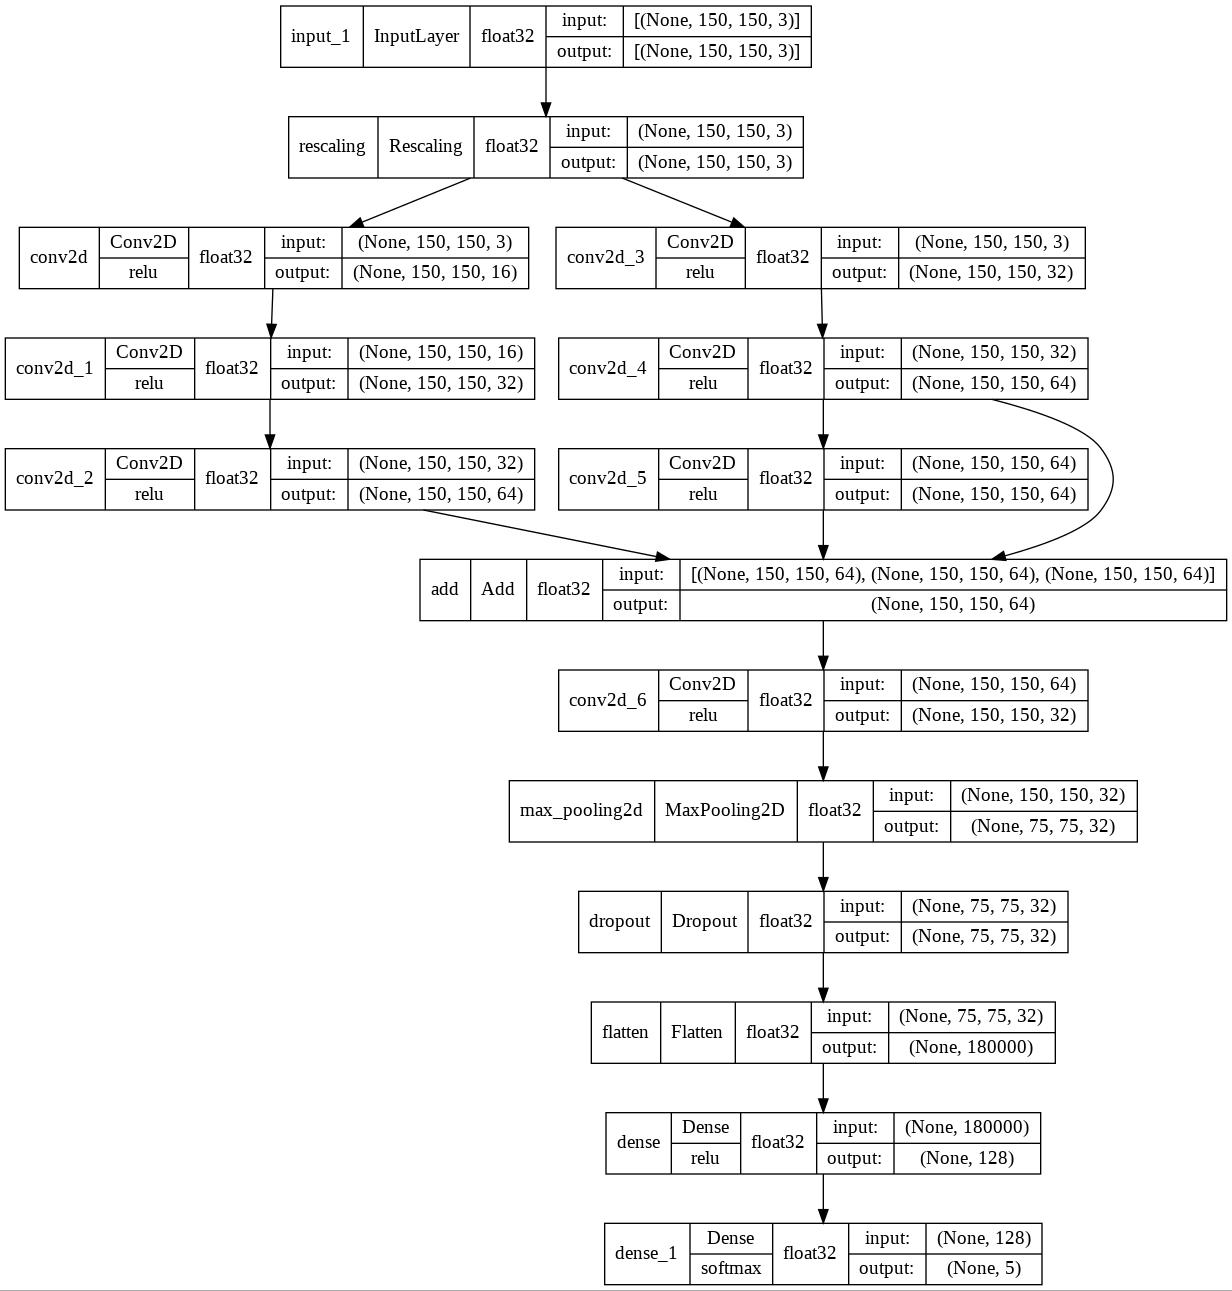

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file='model.jpg',
    show_shapes=True,
    show_dtype=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [23]:
lr = 0.00001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
early_stop = [
    tf.keras.callbacks.EarlyStopping(
        patience=5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        verbose=1,
        monitor='val_loss',
        save_best_weight=True,
        model='auto'
    )
]

In [25]:
history = model.fit(
    train,
    validation_data=validation,
    batch_size=32,
    epochs=50,
    callbacks=early_stop
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 1.5300 - accuracy: 0.3101
Epoch 00001: saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


108/108 [==============================] - 55s 383ms/step - loss: 1.5300 - accuracy: 0.3101 - val_loss: 1.3941 - val_accuracy: 0.3852
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 1.3415 - accuracy: 0.4296
Epoch 00002: saving model to model.h5
108/108 [==============================] - 37s 341ms/step - loss: 1.3415 - accuracy: 0.4296 - val_loss: 1.2470 - val_accuracy: 0.4756
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 1.1936 - accuracy: 0.5038
Epoch 00003: saving model to model.h5
108/108 [==============================] - 37s 341ms/step - loss: 1.1936 - accuracy: 0.5038 - val_loss: 1.1377 - val_accuracy: 0.5104
Epoch 4/50
108/108 [==============================] - ETA: 0s - loss: 1.1009 - accuracy: 0.5533
Epoch 00004: saving model to model.h5
108/108 [==============================] - 37s 341ms/step - loss: 1.1009 - accuracy: 0.5533 - val_loss: 1.0935 - val_accuracy: 0.5592
Epoch 5/50
108/108 [==============================] - ETA: 0s 

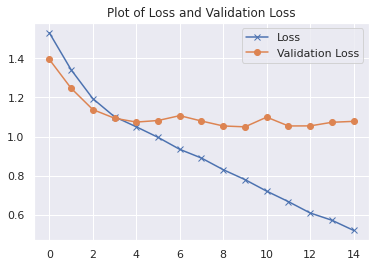

In [26]:
sns.set_theme()
plt.plot(history.history['loss'], '-x',label='Loss')
plt.plot(history.history['val_loss'], '-o',label='Validation Loss')
plt.legend()
plt.title('Plot of Loss and Validation Loss')
plt.show()

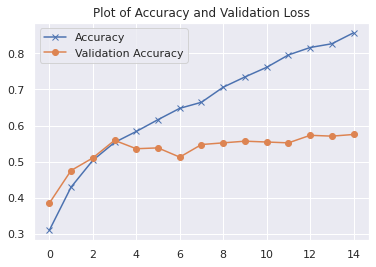

In [27]:
sns.set_theme()
plt.plot(history.history['accuracy'], '-x', label='Accuracy')
plt.plot(history.history['val_accuracy'], '-o', label='Validation Accuracy')
plt.legend()
plt.title('Plot of Accuracy and Validation Loss')
plt.show()

In [28]:
model.evaluate(validation)

14/14 [==============================] - 2s 105ms/step - loss: 1.0774 - accuracy: 0.5754


[1.0773942470550537, 0.575406014919281]

In [35]:
model2 = Sequential([
                    Input(shape=(img_height, img_width, 3)),
                    Rescaling(1./255),
                    Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.2),
                    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.2),
                    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.5),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(node, activation='softmax')
])

In [36]:
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                    

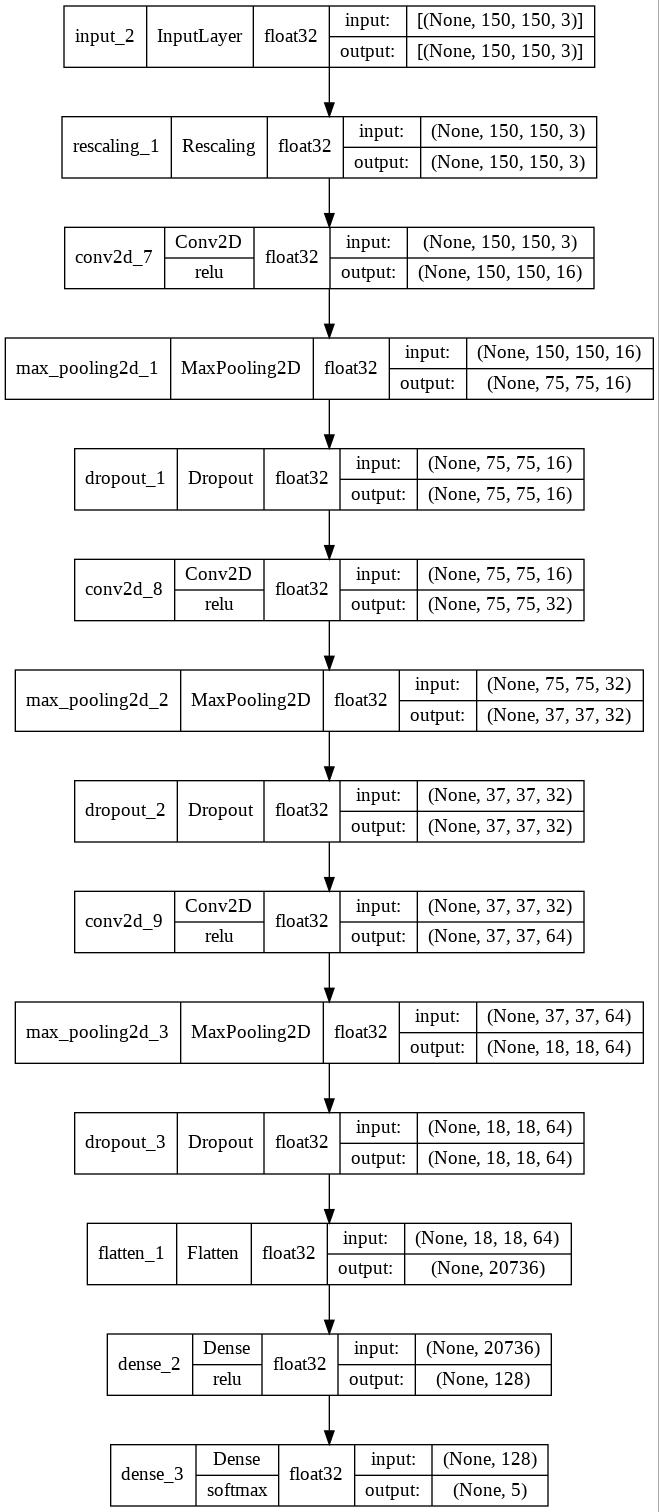

In [39]:
tf.keras.utils.plot_model(
    model2,
    to_file='model2.jpg',
    show_shapes=True, 
    show_dtype=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [40]:
early_stop2 = [
    tf.keras.callbacks.EarlyStopping(
        patience=5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model2.h5',
        verbose=1,
        monitor='val_loss',
        save_best_weight=True,
        model='auto'
    )
]

In [41]:
history = model2.fit(
    train,
    validation_data=validation,
    epochs=50,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 1.3914 - accuracy: 0.4082
Epoch 00001: saving model to model.h5
108/108 [==============================] - 6s 49ms/step - loss: 1.3914 - accuracy: 0.4082 - val_loss: 1.2303 - val_accuracy: 0.4687
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 1.1244 - accuracy: 0.5327
Epoch 00002: saving model to model.h5
108/108 [==============================] - 5s 41ms/step - loss: 1.1244 - accuracy: 0.5327 - val_loss: 1.1136 - val_accuracy: 0.5267
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 1.0209 - accuracy: 0.5953
Epoch 00003: saving model to model.h5
108/108 [==============================] - 5s 43ms/step - loss: 1.0209 - accuracy: 0.5953 - val_loss: 1.0531 - val_accuracy: 0.5545
Epoch 4/50
108/108 [==============================] - ETA: 0s - loss: 0.9300 - accuracy: 0.6430
Epoch 00004: saving model to model.h5
108/108 [==============================] - 5s 42ms/step - loss: 0.93

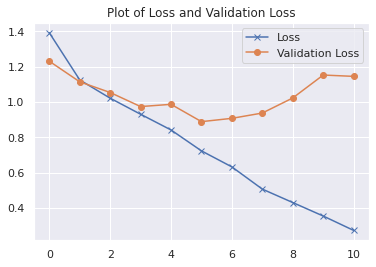

In [44]:
sns.set_theme()
plt.plot(history.history['loss'], '-x',label='Loss')
plt.plot(history.history['val_loss'], '-o',label='Validation Loss')
plt.legend()
plt.title('Plot of Loss and Validation Loss')
plt.show()

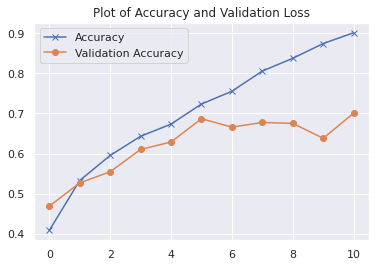

In [45]:
sns.set_theme()
plt.plot(history.history['accuracy'], '-x', label='Accuracy')
plt.plot(history.history['val_accuracy'], '-o', label='Validation Accuracy')
plt.legend()
plt.title('Plot of Accuracy and Validation Loss')
plt.show()

In [47]:
model2.evaluate(validation)

14/14 [==============================] - 0s 22ms/step - loss: 1.1444 - accuracy: 0.7007


[1.1444040536880493, 0.7006960511207581]